In [19]:
import os
import sys

import geopandas as gpd
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
from geopandas import GeoDataFrame
from shapely.geometry import Point

In [4]:
PROJECT_PATH = os.path.join(os.path.abspath(""), os.pardir)
print(PROJECT_PATH)
DATASET_DIR = os.path.join(PROJECT_PATH, "data/ny-2015-street-tree-census/data_content")
DATASET_DATA_PATH = os.path.join(DATASET_DIR, "2015-street-tree-census-tree-data.csv")
DATASET_METADATA_PATH = os.path.join(DATASET_DIR, "socrata_metadata.json")

/home/clement/Courses/Other/ods_mlops/code/ods-mlops-2024/notebooks/..



## Load dataset

In [5]:
df = pd.read_csv(DATASET_DATA_PATH)

df.head()

tree_id  block_id               created_at  tree_dbh  stump_diam curb_loc  \
0   180683    348711  2015-08-27T00:00:00.000         3           0   OnCurb   
1   200540    315986  2015-09-03T00:00:00.000        21           0   OnCurb   
2   204026    218365  2015-09-05T00:00:00.000         3           0   OnCurb   
3   204337    217969  2015-09-05T00:00:00.000        10           0   OnCurb   
4   189565    223043  2015-08-30T00:00:00.000        21           0   OnCurb   

  status health                           spc_latin       spc_common  ...  \
0  Alive   Fair                         Acer rubrum        red maple  ...   
1  Alive   Fair                   Quercus palustris          pin oak  ...   
2  Alive   Good  Gleditsia triacanthos var. inermis      honeylocust  ...   
3  Alive   Good  Gleditsia triacanthos var. inermis      honeylocust  ...   
4  Alive   Good                     Tilia americana  American linden  ...   

   boro_ct     state   latitude  longitude         x_sp         y_sp  \
0  4073900  New York  40.723092 -73.844215  1027431.148  202756.7687   
1  4097300  New York  40.794111 -73.818679  1034455.701  228644.8374   
2  3044900  New York  40.717581 -73.936608  1001822.831  200716.8913   
3  3044900  New York  40.713537 -73.934456  1002420.358  199244.2531   
4  3016500  New York  40.666778 -73.975979   990913.775  182202.4260   

  council district census tract        bin           bbl  
0             29.0        739.0  4052307.0  4.022210e+09  
1             19.0        973.0  4101931.0  4.044750e+09  
2             34.0        449.0  3338310.0  3.028870e+09  
3             34.0        449.0  3338342.0  3.029250e+09  
4             39.0        165.0  3025654.0  3.010850e+09  

[5 rows x 45 columns]

In [6]:
df.dtypes

tree_id               int64
block_id              int64
created_at           object
tree_dbh              int64
stump_diam            int64
curb_loc             object
status               object
health               object
spc_latin            object
spc_common           object
steward              object
guards               object
sidewalk             object
user_type            object
problems             object
root_stone           object
root_grate           object
root_other           object
trunk_wire           object
trnk_light           object
trnk_other           object
brch_light           object
brch_shoe            object
brch_other           object
address              object
postcode              int64
zip_city             object
community board       int64
borocode              int64
borough              object
cncldist              int64
st_assem              int64
st_senate             int64
nta                  object
nta_name             object
boro_ct             

## Analyze missing data

In [7]:
missing_ratio = 1 - df.count() / len(df)
missing_ratio[missing_ratio > 0]

health              0.046237
spc_latin           0.046241
spc_common          0.046241
steward             0.759648
guards              0.883201
sidewalk            0.046237
problems            0.669716
council district    0.009534
census tract        0.009534
bin                 0.013979
bbl                 0.013979
dtype: float64

In [8]:
d = missing_ratio[missing_ratio > 0]
fig = px.pie(
    names=d.index, values=d.values, title="Missing values in dataset", width=600
)
fig.show()

## Pairwise feature distribution diagrams

In [9]:
columns = ["tree_dbh", "stump_diam", "cncldist", "st_assem", "st_senate"]

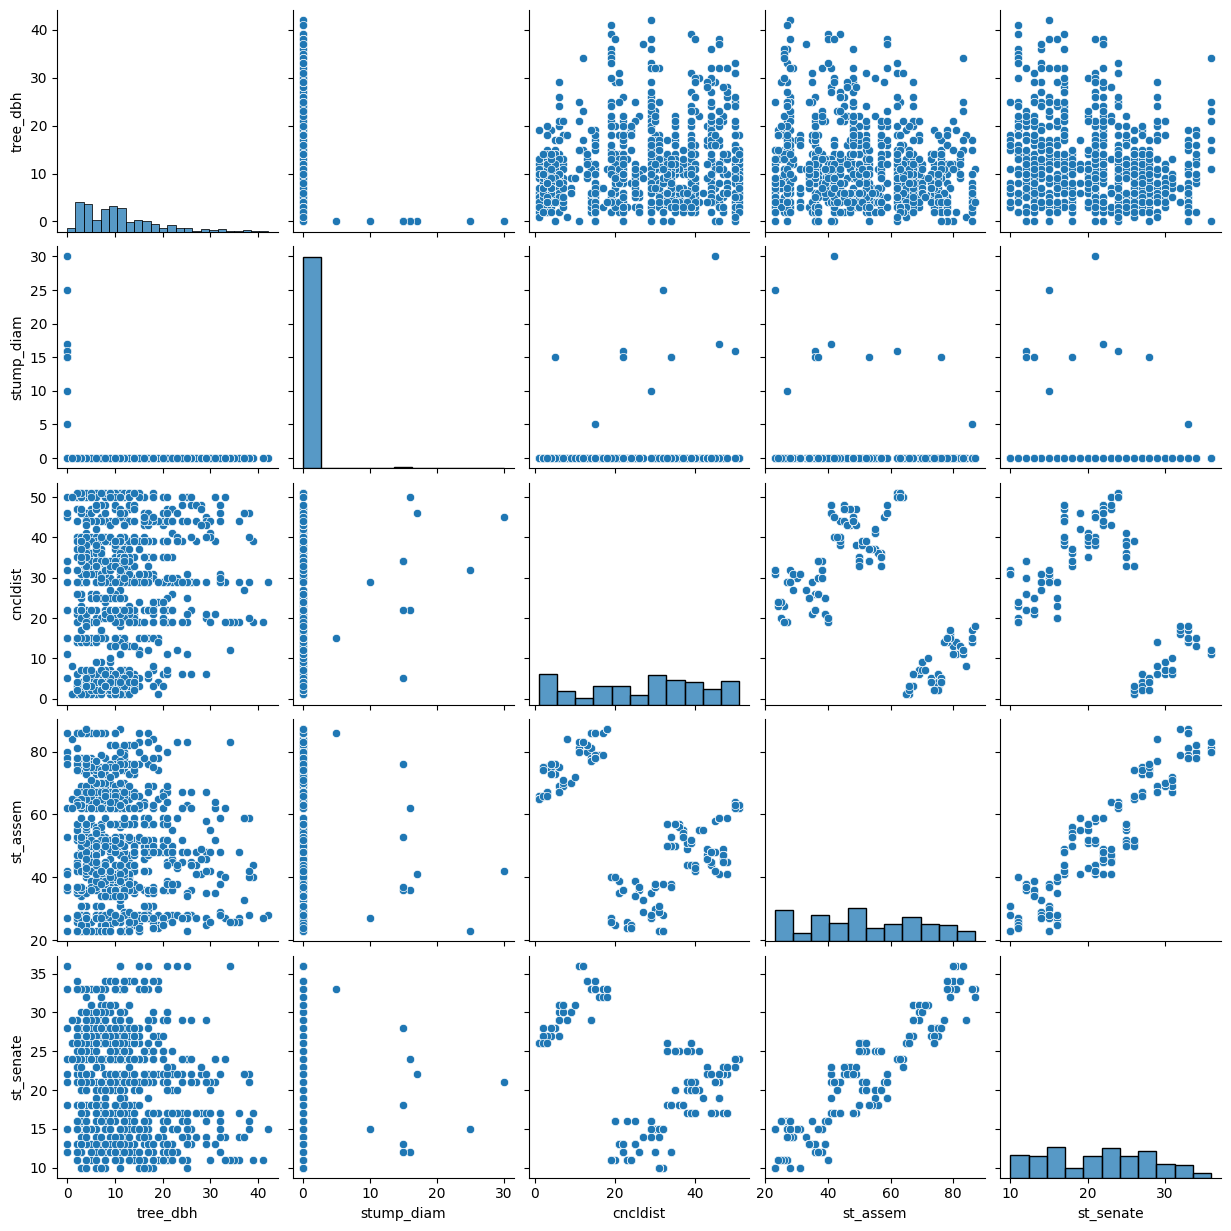

In [13]:
sns.pairplot(data=df[columns][:1000])

## Real valued features correlation matrix

In [15]:
df_float = df.select_dtypes(include=["float64"])
df_float

latitude  longitude          x_sp         y_sp  council district  \
0       40.723092 -73.844215  1.027431e+06  202756.7687              29.0   
1       40.794111 -73.818679  1.034456e+06  228644.8374              19.0   
2       40.717581 -73.936608  1.001823e+06  200716.8913              34.0   
3       40.713537 -73.934456  1.002420e+06  199244.2531              34.0   
4       40.666778 -73.975979  9.909138e+05  182202.4260              39.0   
...           ...        ...           ...          ...               ...   
683783  40.713211 -73.954944  9.967407e+05  199121.6363              34.0   
683784  40.715194 -73.856650  1.023989e+06  199873.6475              29.0   
683785  40.620762 -74.136517  9.463514e+05  165466.0763              50.0   
683786  40.850828 -73.903115  1.011054e+06  249271.9507              15.0   
683787  40.732165 -73.787526  1.043136e+06  206095.5383              24.0   

        census tract        bin           bbl  
0              739.0  4052307.0  4.022210e+09  
1              973.0  4101931.0  4.044750e+09  
2              449.0  3338310.0  3.028870e+09  
3              449.0  3338342.0  3.029250e+09  
4              165.0  3025654.0  3.010850e+09  
...              ...        ...           ...  
683783         519.0  3062513.0  3.023690e+09  
683784         707.0  4075448.0  4.031810e+09  
683785         201.0  5011657.0  5.004080e+09  
683786       23502.0  2007757.0  2.028120e+09  
683787        1341.0  4153657.0  4.071360e+09  

[683788 rows x 8 columns]

In [17]:
corr = df_float.corr()
corr

latitude  longitude      x_sp      y_sp  council district  \
latitude          1.000000   0.572289  0.571812  0.999999         -0.886017   
longitude         0.572289   1.000000  0.999999  0.572757         -0.557000   
x_sp              0.571812   0.999999  1.000000  0.572280         -0.556669   
y_sp              0.999999   0.572757  0.572280  1.000000         -0.886092   
council district -0.886017  -0.557000 -0.556669 -0.886092          1.000000   
census tract     -0.014834   0.220531  0.220356 -0.014404         -0.018348   
bin              -0.628894  -0.152223 -0.152314 -0.628408          0.670766   
bbl              -0.626599  -0.178745 -0.178864 -0.626121          0.672369   

                  census tract       bin       bbl  
latitude             -0.014834 -0.628894 -0.626599  
longitude             0.220531 -0.152223 -0.178745  
x_sp                  0.220356 -0.152314 -0.178864  
y_sp                 -0.014404 -0.628408 -0.626121  
council district     -0.018348  0.670766  0.672369  
census tract          1.000000  0.183009  0.174843  
bin                   0.183009  1.000000  0.996809  
bbl                   0.174843  0.996809  1.000000

<Axes: >

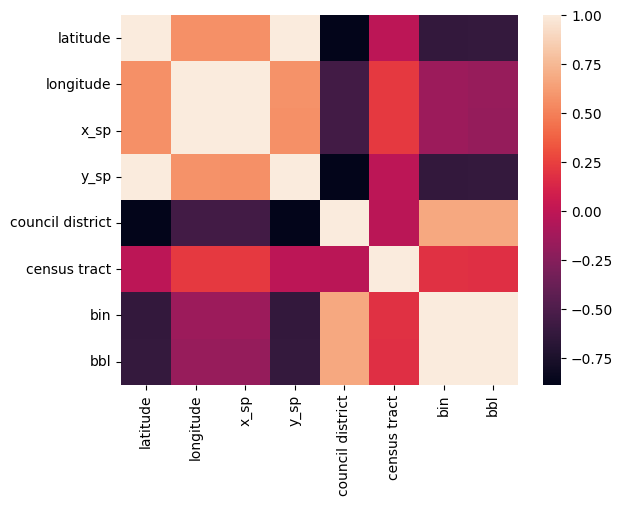

In [18]:
sns.heatmap(corr)

## Show trees on the map

/tmp/ipykernel_59138/382379177.py:3: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



<Axes: >

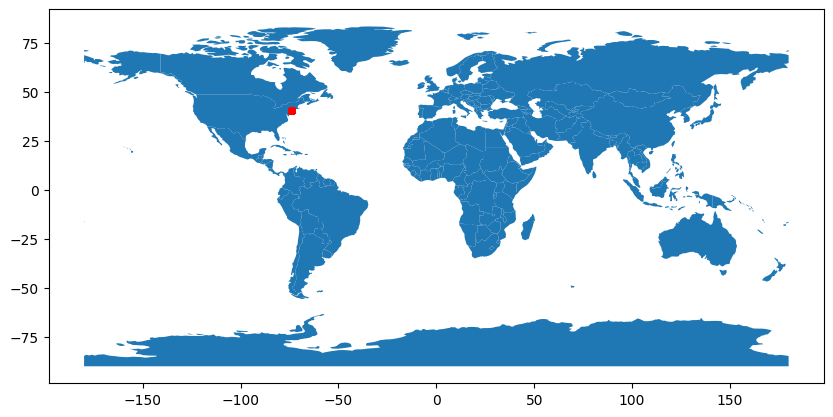

In [32]:
points = list(map(Point, zip(df["longitude"], df["latitude"])))
gdf = GeoDataFrame(df[["latitude", "longitude"]], geometry=points)
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker="o", color="red", markersize=15)